#### САМОСТОЯТЕЛЬНАЯ РАБОТА
#### МОДУЛЬ OD-3 Принятие решения по результатам А/Б теста

#### Задачи:
- Рассчитать, насколько различаются конверсия, средний чек и ARPU пользователей в группах А и Б (ID теста 127, даты проведения: с 2019-08-05 до 2019-08-11 включительно).
- Сформировать выводы по анализу.

#### Примечание:
- для решения необходимо использовать тест с ID 127, который проводили с 2019-08-05 до 2019-08-11 включительно.

#### Критерии оценки:
1. Отсутствие ошибок: ноутбук открывается без ошибок.
2. Рассчитан средний чек.
3. Рассчитан ARPU.
4. Представлены выводы, сделанные на основе анализа.

#### Требования к ответу:
- Ответ должен быть в виде ipynb-файла.
- Ipynb-файл должен запускаться и выполняться без необходимости изменять порядок действий. То есть при нажатии кнопки Restart Kernel & Re-run the whole notebook ноутбук должен выполниться без ошибок и выдать в конце результат проверки второй гипотезы.
- Результатом выполнения задания является написанный алгоритм, который производит вычисления и выводит данные, на основе которых можно подтвердить или опровергнуть гипотезу.
- Обязательно наличие выводов в формате ячеек с Markdown.
- Большим плюсом (но это не обязательное условие) будет, если в ходе алгоритма даны комментарии к коду (в виде комментариев Python или в разметке Markdown в Jupyter Notebook) с описанием назначения создаваемых переменных и выражений.

In [1]:
# Импорты нужных библиотек и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro 
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime


In [2]:
# Читаем таблицу ab_test_groups
ab_test_groups=pd.read_csv('ab_test_groups.csv')
ab_test_groups.head()

,user_id,grp,ab_test_id
0,1,B,132
1,2,A,132
2,3,B,132
3,4,A,132
4,5,B,132


In [3]:
# Выбираем тест с ID 127
ab_test_groups_2=ab_test_groups[ab_test_groups['ab_test_id']==127]
ab_test_groups_2.head()

,user_id,grp,ab_test_id
11999,1,B,127
12000,2,B,127
12001,3,B,127
12002,4,B,127
12003,5,A,127


In [4]:
# Читаем таблицу payments
payments=pd.read_csv('payments.csv')
payments.head()

,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off


In [5]:
#Переведем столбец created_at в формат datetime
#Выберем тест, который проводили с 2019-08-05 до 2019-08-11 включительно.
payments['created_at']=pd.to_datetime(payments['created_at'])
payments=payments[(payments['created_at']>='2019-08-05')&(payments['created_at']<'2019-08-12')]
payments.head()

,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off


In [6]:
# Оставим только два столбца user_id и price
payments_2=payments[['user_id', 'price']]
payments_2.head()

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0


In [7]:
# Т.к. у одного пользователя может быть несколько покупок, сделаем агрегацию по пользователю
payments_2=payments_2.groupby('user_id', as_index=False).agg({'price':'sum'})
payments_2

,user_id,price
0,1,140.0
1,10,140.0
2,23,140.0
3,24,700.0
4,39,140.0
...,...,...
13701,153184,140.0
13702,153190,140.0
13703,153205,140.0
13704,153212,700.0


In [8]:
# Объединим эти таблицы, чтобы осталась сводная информация обо всех участниках теста и покупках каждого из них за время теста.
ab_data_2=ab_test_groups_2.merge(payments_2,on= 'user_id', how='left')
ab_data_2.head()

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN


In [9]:
# Посмотрим, в каких пропорциях разбиты пользователи на группы и количество пользователей, совершивших покупку
ab_summary_2=ab_data_2.groupby('grp', as_index=True).agg({'user_id':'count', 'price':'count'})
ab_summary_2=ab_summary_2.rename(columns={'user_id':'users_count', 'price':'buyers_count'})
ab_summary_2

,users_count,buyers_count
grp,,
A,76605,4279
B,76627,9427


In [10]:
#Посчитаем какая доля пользователей находится в группе А
percent_A=ab_summary_2.loc[ab_summary_2.index=='A']['users_count']/ab_summary_2['users_count'].sum()*100                                                    
percent_A

grp
A    49.992821
Name: users_count, dtype: float64

В группе А — 49,993 % пользователей, из чего можем сделать вывод, что использована разбивка 50/50. При этом количество покупателей существенно различается.

In [11]:
#Посчитаем коэффициент конверсии
ab_summary_2['conversion']=ab_summary_2['buyers_count']/ab_summary_2['users_count']
ab_summary_2

,users_count,buyers_count,conversion
grp,,,
A,76605,4279,0.055858
B,76627,9427,0.123025


Конверсия серьёзно различается: в первой группе она составляет 5,6 %, а во второй — целых 12,3 %!

In [12]:
#Посчитаем общую прибыль по каждой группе
ab_summary_2 = ab_summary_2.merge(ab_data_2.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), 
                 left_index = True, right_index = True) # Сделали агрегацию и прикрепили её к ab_summary
ab_summary_2

,users_count,buyers_count,conversion,revenue
grp,,,,
A,76605,4279,0.055858,1695000.0
B,76627,9427,0.123025,3288180.0


In [13]:

percent_revenue_A=ab_summary_2[ab_summary_2.index=='A']['revenue']/ab_summary_2['revenue'].sum()*100
percent_revenue_A

grp
A    34.014425
Name: revenue, dtype: float64

In [14]:
# Посчитаем долю прибыли группы Б от общей прибыли
percent_revenue_B=ab_summary_2[ab_summary_2.index=='B']['revenue']/ab_summary_2['revenue'].sum()*100
percent_revenue_B

grp
B    65.985575
Name: revenue, dtype: float64

Выручка группы А - 34, а выручка группы B - 66% общей выручки

In [15]:
# Посчитаем средний чек
ab_summary_2['avg_bill']=ab_summary_2['revenue']/ab_summary_2['buyers_count']
ab_summary_2

,users_count,buyers_count,conversion,revenue,avg_bill
grp,,,,,
A,76605,4279,0.055858,1695000.0,396.120589
B,76627,9427,0.123025,3288180.0,348.804498


In [16]:
# Посчитаем на сколько % снизился средний чек в группе B по сравнению с группой А
difference_avg_bill=100-ab_summary_2.loc['B','avg_bill']/ab_summary_2.loc['A','avg_bill']*100
difference_avg_bill

11.944870457760672

Несмотря на то что скидка в группе Б составляет 30%, средний чек упал на 11,94%.
Видимо, из-за акции также стали покупать больше годовых подписок.

In [17]:
#Посчитаем ARPU
ab_summary_2['ARPU']=ab_summary_2['revenue']/ab_summary_2['users_count']
ab_summary_2

,users_count,buyers_count,conversion,revenue,avg_bill,ARPU
grp,,,,,,
A,76605,4279,0.055858,1695000.0,396.120589,22.126493
B,76627,9427,0.123025,3288180.0,348.804498,42.911506


In [18]:
# Посчитаем на сколько ARPU в группе B больше, чем в группе А
ab_summary_2.loc['B','ARPU']-ab_summary_2.loc['A','ARPU']

20.785013339331144

In [19]:
# Посчитаем на сколько % увеличился ARPU в группе B по сравнению с группой А
ab_summary_2.loc['B','ARPU']/ab_summary_2.loc['A','ARPU']*100-100

93.9372240035081

Наличие скидки в группе Б увеличило ARPU на 93% (на 20,78 рублей)

In [20]:
#Посчитаем доп.выручку
ab_summary_2['Доп. выручка'] = ab_summary_2['users_count']*(ab_summary_2['ARPU'] - ab_summary_2.loc['A', 'ARPU'])
ab_summary_2

,users_count,buyers_count,conversion,revenue,avg_bill,ARPU,Доп. выручка
grp,,,,,,,
A,76605,4279,0.055858,1695000.0,396.120589,22.126493,0.000000e+00
B,76627,9427,0.123025,3288180.0,348.804498,42.911506,1.592693e+06


Дополнительная выручка - 1 592 693 рубля

In [21]:
#Расчет статистической значимости с использованием Z-теста (исп.данный тест, т.к. конверсия - бинарная величина)
ztest(ab_data_2.loc[ab_data_2['grp']=='A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0),\
ab_data_2.loc[ab_data_2['grp']=='B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0))

(-46.38627328408593, 0.0)

P-значение в данном случае равно нулю, что позволяет говорить о фактическом улучшении конверсии (статистически значимо) 

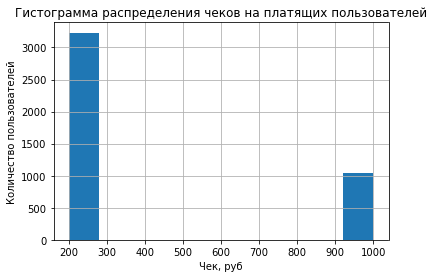

Shapiro-Wilk p-value is ShapiroResult(statistic=0.5343698859214783, pvalue=0.0)


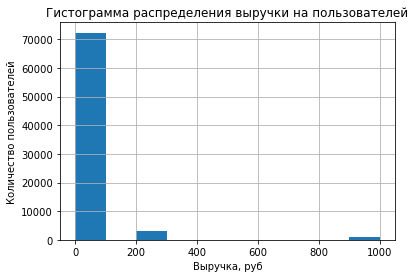

Shapiro-Wilk p-value is ShapiroResult(statistic=0.1714773178100586, pvalue=0.0)


In [34]:
#Рассмотрим различия среднего чека и ARPU
ax = plt.subplot()
ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].dropna()))

ax = plt.subplot()
ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].fillna(0)))


И визуальный анализ, и тест Шапиро-Вилка на нормальность говорят нам, что распределение не является нормальным.

In [23]:
#Сравниваем средние чеки, применив тест Манна-уитни
print(stats.mannwhitneyu(ab_data_2.loc[ab_data_2['grp']=='A','price'].dropna(),ab_data_2.loc[ab_data_2['grp']=='B','price'].dropna()),
stats.ttest_ind(ab_data_2.loc[ab_data_2['grp']=='A','price'].dropna(), ab_data_2.loc[ab_data_2['grp']=='B','price'].dropna()),\
      sep = '\n')

MannwhitneyuResult(statistic=11353450.0, pvalue=0.0)
Ttest_indResult(statistic=8.681488291725874, pvalue=4.342920451712972e-18)


Средние чеки значимо различаются (так как p-значение << 0.05) по каждому из тестов.

In [24]:
# Сравниваем ARPU
print(stats.mannwhitneyu(ab_data_2.loc[ab_data_2.grp == 'A', 'price'].fillna(0), ab_data_2.loc[ab_data_2.grp == 'B', 'price'].fillna(0)),
      stats.ttest_ind(ab_data_2.loc[ab_data_2.grp == 'A', 'price'].fillna(0), ab_data_2.loc[ab_data_2.grp == 'B', 'price'].fillna(0)),
     sep = '\n')

MannwhitneyuResult(statistic=2746687083.0, pvalue=0.0)
Ttest_indResult(statistic=-29.893345238870868, pvalue=8.818064407002295e-196)


ARPU значимо различаются (так как p-значение << 0.05) по каждому из тестов.

In [25]:
#Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  
# Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
#Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [26]:
get_conf_interval(ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].fillna(0)) 
#Доверительный полуинтервал для АРПУ пользователей в группе А

0.8641428736438357

In [27]:
#Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].fillna(0)),
                          'B':get_conf_interval(ab_data_2.loc[ab_data_2['grp'] == 'B', 'price'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].dropna().count(),
                                                        ab_data_2.loc[ab_data_2['grp'] == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(ab_data_2.loc[ab_data_2['grp'] == 'B', 'price'].dropna().count(),
                                                        ab_data_2.loc[ab_data_2['grp'] == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_data_2.loc[ab_data_2['grp'] == 'A', 'price'].dropna()),
                          'B':get_conf_interval(ab_data_2.loc[ab_data_2['grp'] == 'B', 'price'].dropna())}
                 }

In [28]:
conf_intervals

{'ARPU': {'A': 0.8641428736438357, 'B': 1.0537383983825563},
 'conversion': {'A': 0.0032524511174824022, 'B': 0.004651325604805509},
 'avg_bill': {'A': 10.315428393735829, 'B': 5.467446406040892}}

In [29]:
#Удобная функция для подстановки подписей на barplot
def set_labels(axes):  
#Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  
#Размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  
#Дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  
#По всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'тыс'
            else:
                label = label + 'тыс'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'млн'
            else:
                label = label + 'млн'
        x = rect.get_x() + rect.get_width() / 2  
#Посередине прямоугольника
        y = height + y_shift * 0.8  
#Над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [30]:
#Транспонированная таблица для удобства использования
plot_summary = ab_summary_2.T 
plot_summary

grp,A,B
users_count,7.660500e+04,7.662700e+04
buyers_count,4.279000e+03,9.427000e+03
conversion,5.585797e-02,1.230245e-01
revenue,1.695000e+06,3.288180e+06
avg_bill,3.961206e+02,3.488045e+02
ARPU,2.212649e+01,4.291151e+01
Доп. выручка,0.000000e+00,1.592693e+06


In [31]:
#Метрики со статзначимыми различиями 
significant_changes = ['conversion', 'avg_bill', 'ARPU'] 

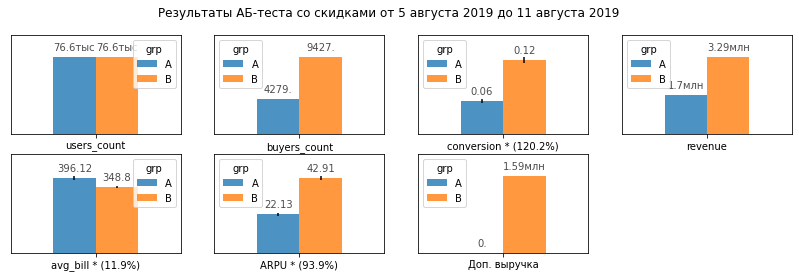

In [32]:
from matplotlib import gridspec
from math import ceil

ax = [] 
# Массив для складирования графиков
n_pict_in_line = 4 
# Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) 
# Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "Доп. выручка" != row and 'avg_bill'!=row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
    elif 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "Доп. выручка" != row and\
    'conversion'!=row and 'ARPU'!=row:
        delta_percent[row] = '(' + str(round(100-plot_summary.loc[row, :].min()/\
                                  plot_summary.loc[row, :].max()*100,1)) + '%)'   
fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

## Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) 
# Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, 
# Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    
# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

#### ВЫВОД:
1. Введение скидок способствовало:
- значимому увеличению ARPU на 93%
- значимому увеличению конверсии на 120%
- значимому падению среднего чека на 11,9%.

2. Дополнительная выручка составила - 1 592 693 рубля

Введение скидок значительно увеличило прибыль